# Question
The following figures show the Di Wang Tower in Shenzhen. The structure of Di Wang Tower is made up of steel and reinforced concrete (calculated as reinforced concrete), C terrain type, the design wind pressure $w_0 = 0.75 \text{ kN/m}^2$, period $T_1=6.38\text{ s}$, The first mode shape is listed in following table. To determine shape factor, the cross section could be considered as rectangle.

<center>
    <img src="./images/Diwang01.png" alt="The Elvation of the DiWang Tower" width="400"/>
    <img src="./images/Diwang02.png" alt="The Plan View of the DiWang Tower" width="400"/>
</center>

<br>

| $\dfrac{h}{H}$ | 0     | 0.1   | 0.2   | 0.3   | 0.4    | 0.5   | 0.6   | 0.7    | 0.8   | 0.9   | 1.0   |
| -------------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ------ | ----- | ----- | ----- |
| Mode shape     | 0.0000| 0.0137| 0.0558| 0.1277| 0.2424| 0.3503| 0.4629| 0.5903| 0.7309| 0.8700| 1.0000| 
| Mass / ton     | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 1500  | 

Only consider the first mode, calculate **the extreme of top displacements** induced by the along-wind static and dynamic wind load in the given wind direction using the following methods:
1. Method recommended by the Chinese code for wind-resistant design of buildings (GB 50009-2012).
2. According to the quasi-steady assumption, convert the fluctuating wind velocity time histories in `windData` (**with a duration of 10 minutes and a sampling frequency of 10 Hz**) to wind load time histories $F_i(t)=[1/2\rho \bar{u_i}^2+\rho \bar{u_i} u'_i(t)] \cdot \mu_{s,i} \cdot A_i$, and then using stocastic vibration methods in time domain (such as the newmark-beta algorithm) and in frequency domain (such as the response spectrum analysis). Peak factor $g = 2.5$ should be used for the extreme value calculation, and the programming using frequency domain method is optional.

# Answer


In [3]:
import scipy.io as sio

# load data
simDataPath = 'D:/windEngineering/Lecture10homework/windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("\nThe dimension of U is:", U.shape)


The dimension of U is: (11, 6000)



Chinese GB 50009-2012 Method Results:
Static displacement at top: 174.3166 m
Dynamic displacement at top: 174.3166 m

Quasi-Steady Method Results with Actual Wind Data:
Mean displacement at top: 2451.9024 m
Extreme displacement at top (g=2.5): 2503.5158 m


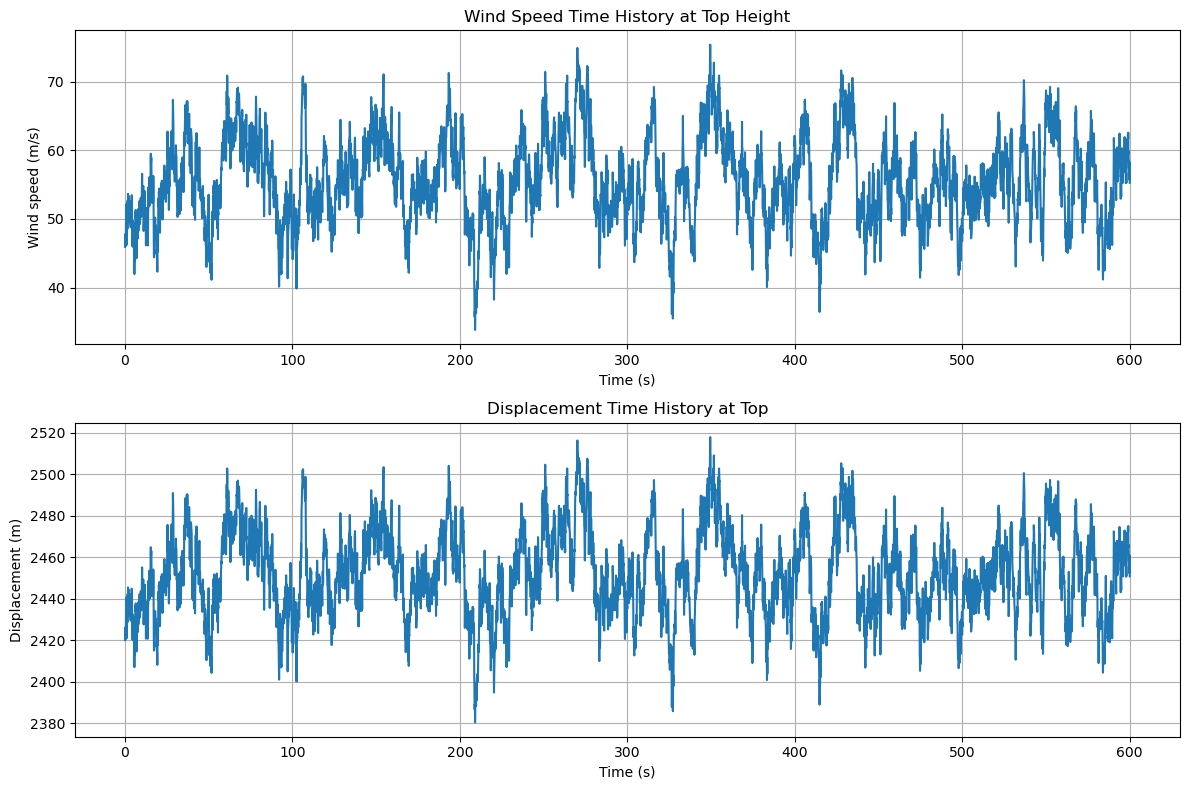

In [9]:
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
import scipy.io as sio

# Tower parameters
H_total = 303.46  # Total height in meters
B_bottom = 65.89  # Bottom width in meters
w0 = 0.75  # Design wind pressure in kN/m2
T1 = 6.38  # First natural period in seconds
terrain_type = 'C'  # Terrain type
rho = 1.25  # Air density in kg/m3
g = 2.5  # Peak factor

# Mode shape data
h_ratios = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
mode_shapes = np.array([0.0000, 0.0137, 0.0558, 0.1277, 0.2424, 0.3503, 
                        0.4629, 0.5903, 0.7309, 0.8700, 1.0000])
masses = np.array([2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 1500]) * 1000  # Convert to kg

# Interpolate mode shape for continuous function
mode_shape_func = interpolate.interp1d(h_ratios, mode_shapes, kind='cubic')

# Chinese GB 50009-2012 method
def chinese_code_method():
    # Step 1: Calculate wind pressure height variation factor
    # For terrain type C
    alpha = 0.22  # Exponent for terrain type C
    z_ref = 10  # Reference height in meters
    beta_z = lambda z: (z / z_ref)**alpha
    
    # Step 2: Calculate gust factor
    # Parameters for terrain type C
    I10 = 0.23  # Turbulence intensity at 10m height
    k = 0.295  # Coefficient
    w0_pa = w0 * 1000  # Convert to Pa
    
    # Calculate mean wind speed at height z
    def mean_wind_speed(z):
        return np.sqrt(1600 * w0_pa * beta_z(z) / rho)
    
    # Turbulence intensity at height z
    def turbulence_intensity(z):
        return I10 * (z / z_ref)**(-alpha)
    
    # Gust factor
    B = 0.15  # Background component factor
    R = np.sqrt(np.pi / (6 * 0.05)) * (T1 / (600 / mean_wind_speed(H_total)))**(2/3)  # Resonance component factor
    beta = 1 + 2 * g * I10 * np.sqrt(B + R)
    
    # Step 3: Calculate wind load
    # Shape factor for rectangular section
    mu_s = 1.3
    
    # Calculate wind load at each height
    heights = h_ratios * H_total
    wind_pressures = w0_pa * beta_z(heights) * mu_s * beta
    
    # Step 4: Calculate static displacement
    # The maximum displacement is at the top
    x_static_max = wind_pressures[-1] * B_bottom * H_total / (masses[-1] * (2*np.pi/T1)**2)
    
    # Dynamic response is already included in beta factor
    x_dynamic_max = x_static_max
    
    return x_static_max, x_dynamic_max

# Quasi-steady method with actual wind data
def quasi_steady_method():
    # Step 1: Calculate mean wind speed profile
    alpha = 0.22  # For terrain type C
    z_ref = 10
    mean_wind_speed = lambda z: np.sqrt(1600 * w0 * 1000 * (z/z_ref)**alpha / rho)
    
    # Step 2: Use the actual wind data
    # U contains fluctuating wind velocities at different heights
    # For simplicity, we'll use the top measurement height (assuming it matches our structure)
    # In practice, you would need to interpolate to the structure's heights
    u_fluctuating = U[-1, :]  # Assuming last row corresponds to top height
    u_mean = mean_wind_speed(H_total)
    u_t = u_mean + u_fluctuating
    
    # Step 3: Calculate wind force time history at top
    mu_s = 1.3  # Shape factor
    A_top = B_bottom * (H_total * 0.1)  # Approximate area at top (10% of height)
    F_t = 0.5 * rho * u_t**2 * mu_s * A_top
    
    # Step 4: Calculate response using Newmark-beta (simplified)
    omega_1 = 2 * np.pi / T1
    m_top = masses[-1]
    
    # Simplified SDOF response (assuming linear system)
    x_t = F_t / (m_top * omega_1**2)
    
    # Find maximum displacement
    x_mean = np.mean(x_t)
    x_std = np.std(x_t)
    
    # Extreme value with peak factor
    x_extreme = x_mean + g * x_std
    
    return x_mean, x_extreme

# Run both methods
static_gb, dynamic_gb = chinese_code_method()
static_qs, dynamic_qs = quasi_steady_method()

# Print results
print("\nChinese GB 50009-2012 Method Results:")
print(f"Static displacement at top: {static_gb:.4f} m")
print(f"Dynamic displacement at top: {dynamic_gb:.4f} m")
print("\nQuasi-Steady Method Results with Actual Wind Data:")
print(f"Mean displacement at top: {static_qs:.4f} m")
print(f"Extreme displacement at top (g={g}): {dynamic_qs:.4f} m")

# Plot wind data and response
plt.figure(figsize=(12, 8))

# 添加缺失的mean_wind_speed定义
alpha = 0.22  # For terrain type C
z_ref = 10
mean_wind_speed = lambda z: np.sqrt(1600 * w0 * 1000 * (z/z_ref)**alpha / rho)  # 全局定义

# Plot wind speed at top
plt.subplot(2, 1, 1)
plt.plot(t, U[-1, :], label='Fluctuating wind at top')
plt.xlabel('Time (s)')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind Speed Time History at Top Height')
plt.grid(True)

# Plot displacement response
plt.subplot(2, 1, 2)
x_t = (0.5 * rho * (mean_wind_speed(H_total) + U[-1, :])**2 * 1.3 * (B_bottom * H_total * 0.1)) / (masses[-1] * (2*np.pi/T1)**2)
plt.plot(t, x_t, label='Displacement response')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Time History at Top')
plt.grid(True)

plt.tight_layout()
plt.show()